# Motivation
The PLOS pipeline was designed as a low pass filter to eliminate noise in the images given to us in the tiff stack. It accomplishes this goal via a series of box filters that convolve all probabilities in a neighborhood, and assign the result to the target voxel.

We found that this method was too harshly degrading the pixels in the image, and eroding away actual synapses, even when the hyperparameters were set such that the algorithm was as lenient as possible.

# Proposed Solution
The algorithm below attempts to maintain the integrity of the PLOS filter, while removing the unnecessary degridation occurring throughout the process. The main idea is as follows:
- For some neighborhood, perform a local adaptive threshold
- Count the number of elements considered foreground in said neighborhood
- Multiply the target voxel's intensity by the ratio of foreground to neighborhood size (density)

In this way, we can continue to use the neighbors to a given voxel as a guide for whether it is relevant or not, while not degrading the element itself. Additionally, the local thresholding will reduce any error due to non-uniform surface intensity, even after normalization.

In [13]:
import sys
sys.path.append('../code/functions')
from connectLib import otsuVox
from plosLib import pipeline as PLOS
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [8]:
data = pickle.load(open('../code/tests/synthDat/realDataRaw_t0.io', 'r'))[170:180]
#data is not normed since volume is only a few slices

In [9]:
def neighborhoodDensity(data, interPlane = 1, intraPlane = 1):
    output = np.zeros_like(data)
    for z in range(data.shape[0]):
        for y in range(data.shape[1]):
            for x in range(data.shape[2]):
                subVol = data[z-intraPlane:z+intraPlane, y-interPlane:y+interPlane, x-interPlane:x+interPlane]
                if not all(subVol.shape) == 0:
                    ave = np.average(subVol)
                    binSubVol = subVol > ave
                    output[z][y][x] = (np.count_nonzero(binSubVol)/float(interPlane*interPlane*intraPlane)) * data[z][y][x]
    return output

In [16]:
%%time
densityMap = neighborhoodDensity(data, 5, 2)

CPU times: user 2min 28s, sys: 544 ms, total: 2min 29s
Wall time: 2min 28s


In [17]:
%%time
plosOut = PLOS(data, 1, 1, 1)

CPU times: user 3min 20s, sys: 392 ms, total: 3min 20s
Wall time: 3min 19s


In [18]:
densityBinOut = otsuVox(densityMap)
plosBinOut = otsuVox(plosOut)

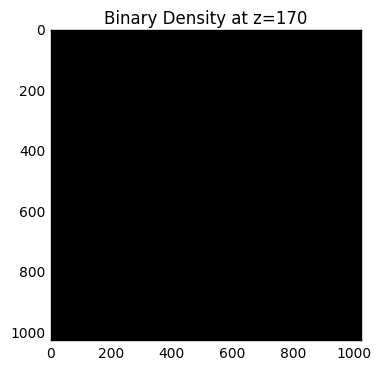

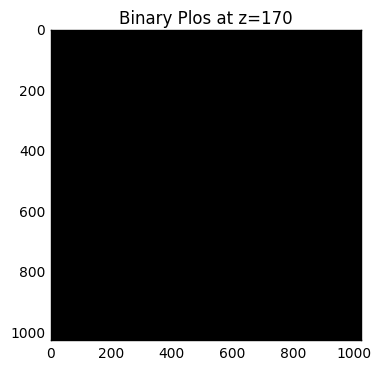

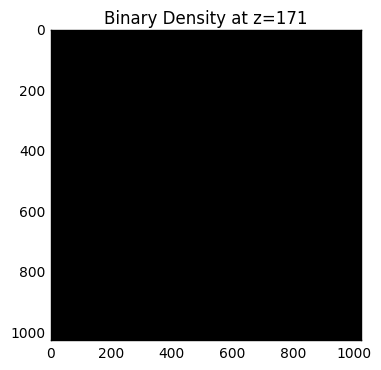

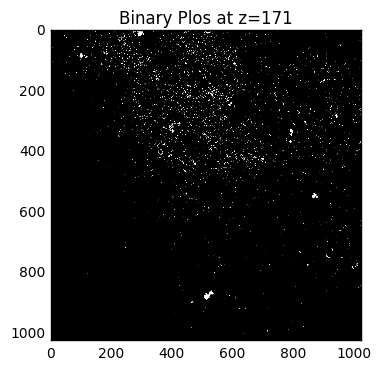

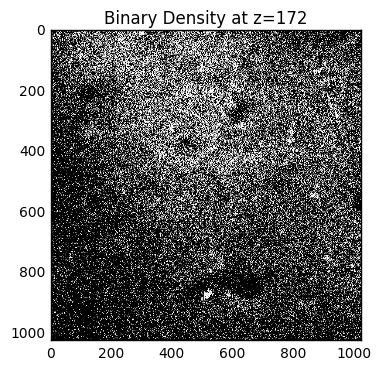

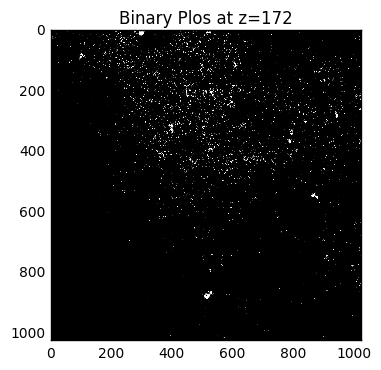

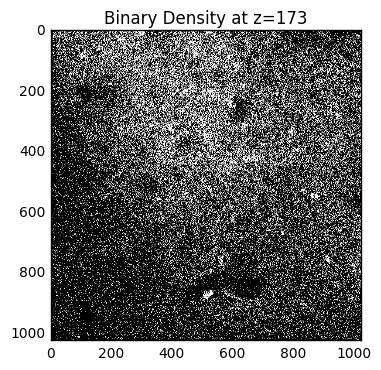

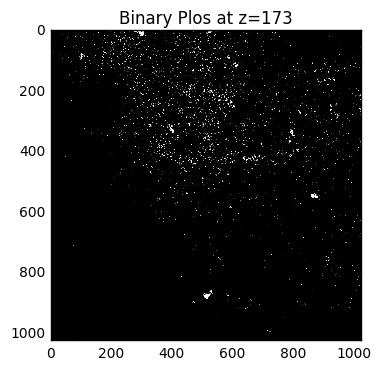

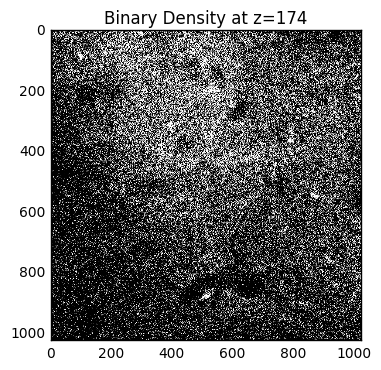

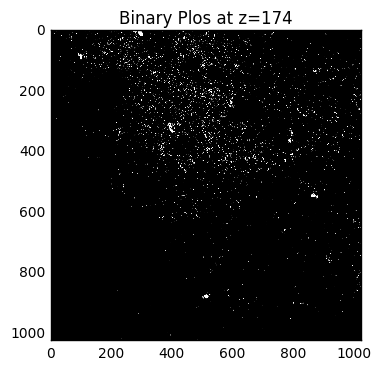

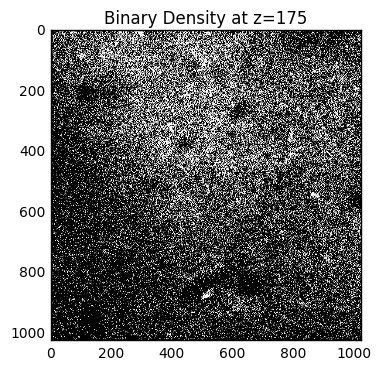

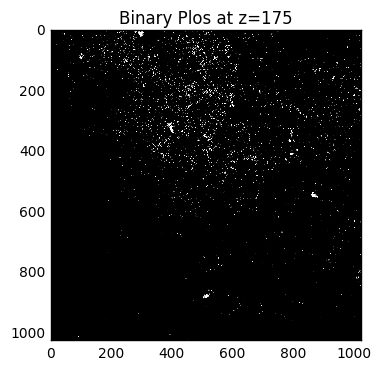

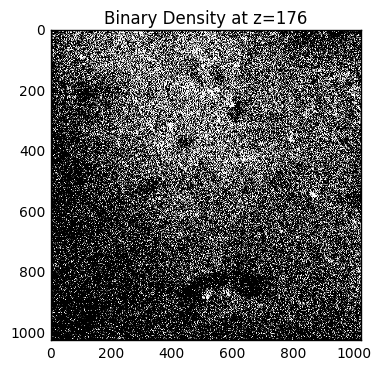

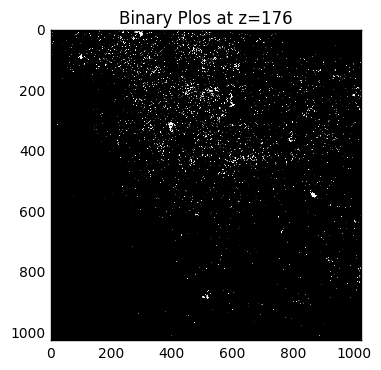

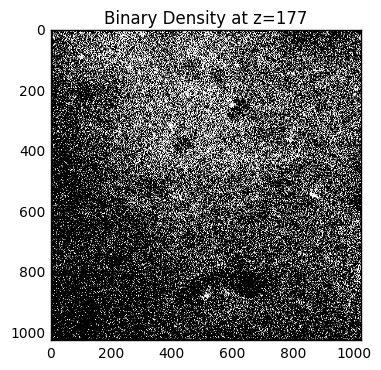

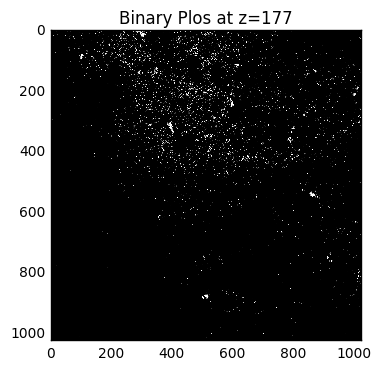

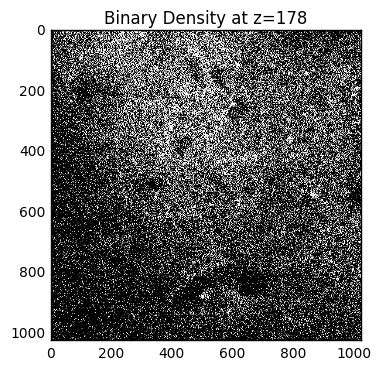

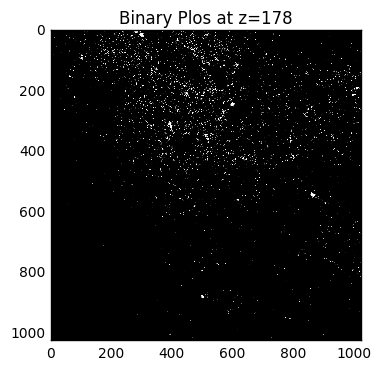

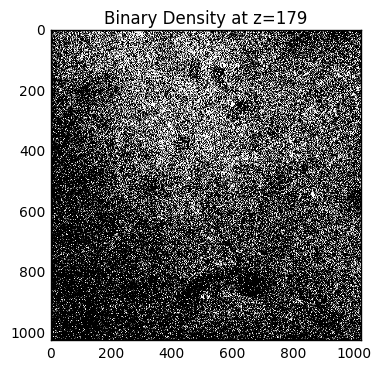

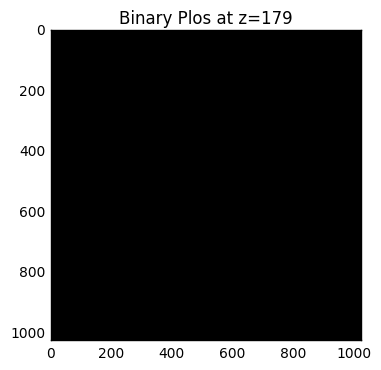

In [21]:
for i in range(densityBinOut.shape[0]):
    fig = plt.figure()
    plt.title('Binary Density at z=' + str(170+i))
    plt.imshow(densityBinOut[i], cmap='gray')
    plt.show()
    fig = plt.figure()
    plt.title('Binary Plos at z=' + str(170+i))
    plt.imshow(plosBinOut[i], cmap='gray')
    plt.show()
    print '\n\n\n'